# Shifted Beta-Geometric Modeling with Cohorts

The Shifted Beta-Geometric (sBG) model was first introduced in ["How to Project Customer Retention"](https://faculty.wharton.upenn.edu/wp-content/uploads/2012/04/Fader_hardie_jim_07.pdf) by Hardie & Fader in 2007, and is ideal for predicting customer behavior in business cases involving contract renewals or recurring subscriptions. In this notebook we will replicate the research results with quick demonstrations of the cohort and covariates capabilities supported by PyMC-Marketing, then proceed to a full example with EDA and predictive methods. 

##### Tutorial Notebook Outstanding Tasks
- [ ] Merge Static Covariate PR
- [ ] Fit regular/highend data to both a cohort and covariate model to replicate research results
- [ ] Synthesize data with covariates & multiple time periods to showcase conventional cohort EDA, additional predictive methods, and dropout distribution plotting

In [1]:
import pytensor

#set flag to hotfix open c++ errors
pytensor.config.cxx = '/usr/bin/clang++'

In [2]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr

from pymc_marketing import clv
import pymc as pm
from pymc_extras.prior import Prior

# Plotting configuration
az.style.use("arviz-darkgrid")
plt.rcParams["figure.figsize"] = [12, 7]
plt.rcParams["figure.dpi"] = 100
plt.rcParams["figure.facecolor"] = "white"

%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [3]:
seed = sum(map(ord, "sBG Model"))
rng = np.random.default_rng(seed)

# Load Data

Data must be aggregrated in the following format for model fitting:

- `customer_id` is an index of unique identifiers for each customer
- `recency` indicates the most recent time period a customer was still active
- `T` is the maximum observed time period for a given cohort
- `cohort` indicates the cohort assignment for each customer

For active customers, `recency` is equal to `T`, and all customers in a given cohort share the same value for `T`. If a customer cancelled their contract and restarted at a later date, an additional `customer_id` must be assigned for the restart.

Sample data is available in the PyMC-Marketing repo. To see the code used to generate this data, refer to `sbg_cohort_data` in `scripts/clv_data_generation.py`.

In [4]:
# TODO: This has been renamed to sbg_reg_hi_cohorts.csv 
dataset = pd.read_csv("https://raw.githubusercontent.com/pymc-labs/pymc-marketing/refs/heads/main/data/sbg_reg_hi_cohorts.csv")
dataset

,customer_id,recency,T,cohort
0,1,1,8,highend
1,2,1,8,highend
2,3,1,8,highend
3,4,1,8,highend
4,5,1,8,highend
...,...,...,...,...
1995,1996,8,8,regular
1996,1997,8,8,regular
1997,1998,8,8,regular
1998,1999,8,8,regular


In [5]:
dataset.describe()

,customer_id,recency,T
count,2000.000000,2000.000000,2000.0
mean,1000.500000,4.508000,8.0
std,577.494589,2.981842,0.0
min,1.000000,1.000000,8.0
25%,500.750000,1.750000,8.0
50%,1000.500000,4.000000,8.0
75%,1500.250000,8.000000,8.0
max,2000.000000,8.000000,8.0


This dataset was generated from the first 8 time periods in Table 1 of the research paper, which provides survival rates for two customer cohorts ("Regular" and "Highend") over 13 time periods:

In [6]:
# Data from research paper
df = pd.DataFrame(
    {
        "regular": [100.0, 63.1, 46.8, 38.2, 32.6, 28.9, 26.2, 24.1, 22.3, 20.7, 19.4, 18.3, 17.3],
        "highend": [100.0, 86.9, 74.3, 65.3, 59.3, 55.1, 51.7, 49.1, 46.8, 44.5, 42.7, 40.9, 39.4],
    }
)
df

,regular,highend
0,100.0,100.0
1,63.1,86.9
2,46.8,74.3
3,38.2,65.3
4,32.6,59.3
5,28.9,55.1
6,26.2,51.7
7,24.1,49.1
8,22.3,46.8
9,20.7,44.5


This is also a useful format for model evaluation. In survival analysis parlance, customers with `recency==T` are "right-censored". If we fit a model to the first 8 time periods, we can test predictions on censored data over the remaining 5 periods:

In [7]:
# Calculate retention percentages for each cohort and time period for testing
# Retention at time t = % of customers with recency >= t
def retention_rate_aggregation(sbg_data: pd.DataFrame):
    """Aggregate sBG data into retention rates over time for model testing."""
    # Group by cohort to get total counts
    cohort_totals = sbg_data.groupby('cohort')['customer_id'].count()
    cohorts = sbg_data["cohort"].unique()
    
    # Create a list to store results for each time period
    results = []
    
    # For each time period from 0 to T (8 in this case)
    for t in range(sbg_data['T'].max()):
        row_data = {'T': t}
    
        for cohort in cohorts:
            cohort_data = sbg_data[sbg_data['cohort'] == cohort]
            total_customers = len(cohort_data)
    
            if t == 0:
                # At time 0, 100% retention
                retention_pct = 100.0
            else:
                # Count customers who survived at least to time t (recency >= t)
                survived = len(cohort_data[cohort_data['recency'] > t])
                retention_pct = (survived / total_customers) * 100
    
            row_data[cohort] = retention_pct
    
        results.append(row_data)
    
    # Convert to DataFrame
    return pd.DataFrame(results)


df_agg = retention_rate_aggregation(dataset)

# Format research data: Assign T column and truncate to 8 periods
df["T"] = df.index
df_test = df[["T","highend","regular"]].query("T<8").copy()

# Assert aggregated dataset is equivalent to the values in the research paper
pd.testing.assert_frame_equal(df_agg,df_test)

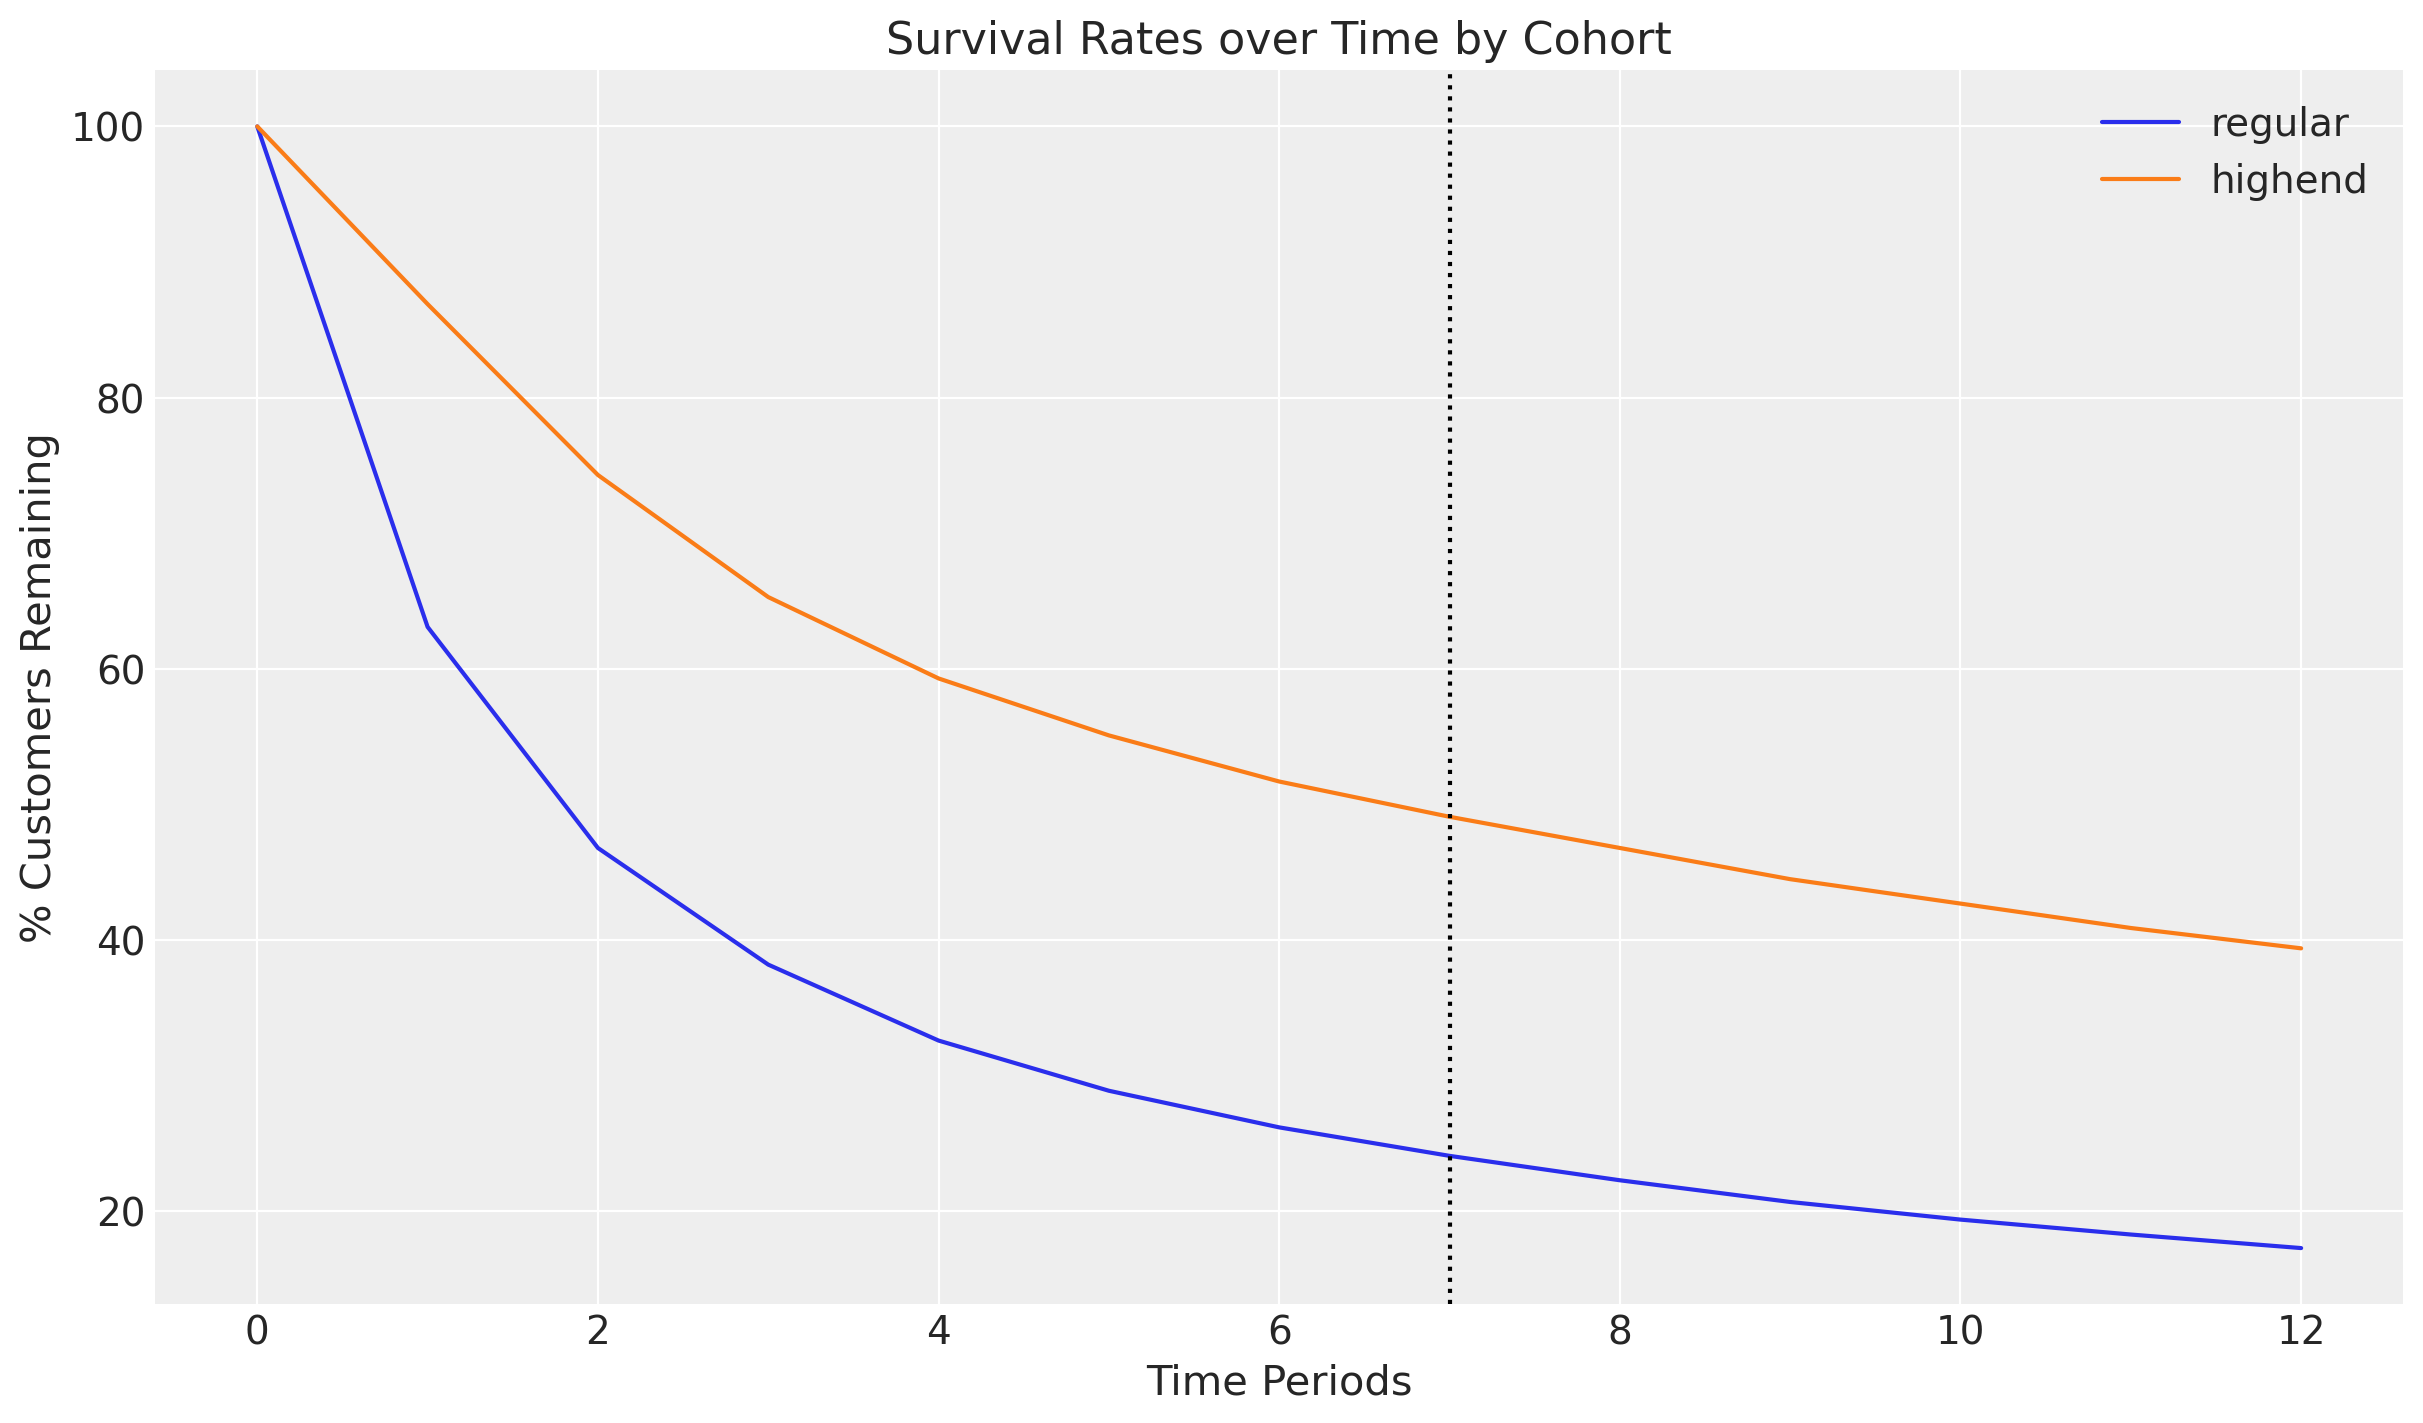

In [8]:
plt.plot(df["regular"].values, label="regular")
plt.plot(df["highend"].values, label="highend")
plt.legend()
plt.ylabel("% Customers Remaining")
plt.xlabel("Time Periods")
plt.axvline(7, ls=":", color="k")
plt.title("Survival Rates over Time by Cohort");

Let's proceed to the modeling step.

In [9]:
### TODO: Create a CLV data generation module in 'scripts/' and move this code there
def individual_data_from_percentage_alive(percentage_alive, initial_customers):
    n_alive = np.asarray(percentage_alive / 100 * initial_customers, dtype=int)

    died_at = np.zeros((initial_customers,), dtype=int)
    counter = 0
    for t, diff in enumerate((n_alive[:-1] - n_alive[1:]), start=1):
        died_at[counter : counter + diff] = t
        counter += diff

    censoring_t = t + 1
    died_at[counter:] = censoring_t

    return died_at


T = 8  # In the paper only the first 7 years are included in the model

truncated_df = df[:T]
initial_customers = 1000  # Seems to be what F&H use, according to Appendix B
churn_highend = individual_data_from_percentage_alive(
    truncated_df["highend"], initial_customers
)
churn_regular = individual_data_from_percentage_alive(
    truncated_df["regular"], initial_customers
)

dataset_highend = pd.DataFrame(
    {
        "recency": churn_highend,
        "T": T,
        "cohort": "highend",
    }
)

dataset_regular = pd.DataFrame(
    {
        "recency": churn_regular,
        "T": T,
        "cohort": "regular",
    }
)

orginal_dataset = pd.concat([dataset_highend,dataset_regular]).reset_index().rename(columns={"index":"customer_id"})
orginal_dataset["customer_id"] = orginal_dataset.index + 1

from pandas.testing import assert_frame_equal
assert_frame_equal(orginal_dataset,dataset)

# Model Fitting

The sBG model has the following assumptions:
* Customer cancellation probabilities are Beta-distributed with hyperparameters `alpha` and `beta`.
* Retention rates change over time due to customer heterogeneity.
* All customers in a given cohort began their contract in the same time period.

In the original frequentist approach, the same-start-time assumption requires fitting separate models to each cohort. However, in PyMC-Marketing we can fit all cohorts in a single hierarchical Bayesian model! Alternatively we could also represent cohorts as covariates in a "single cohort" population model. Let's reproduce research results with both approaches:

## Quick Cohort Example

In [24]:
sbg = clv.ShiftedBetaGeoModel(data=dataset)
sbg.build_model()
sbg.fit(fit_method='mcmc')
sbg.fit_summary(var_names=["alpha","beta"])

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [phi, kappa]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 6 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha[highend],0.671,0.110,0.486,0.878,0.002,0.002,3119.0,3074.0,1.0
alpha[regular],0.702,0.065,0.583,0.830,0.001,0.001,3185.0,2810.0,1.0
beta[highend],3.839,0.856,2.386,5.381,0.017,0.019,2534.0,2643.0,1.0
beta[regular],1.178,0.152,0.891,1.445,0.003,0.003,2207.0,2380.0,1.0


array([[<Axes: title={'center': 'alpha'}>,
        <Axes: title={'center': 'alpha'}>],
       [<Axes: title={'center': 'beta'}>,
        <Axes: title={'center': 'beta'}>]], dtype=object)

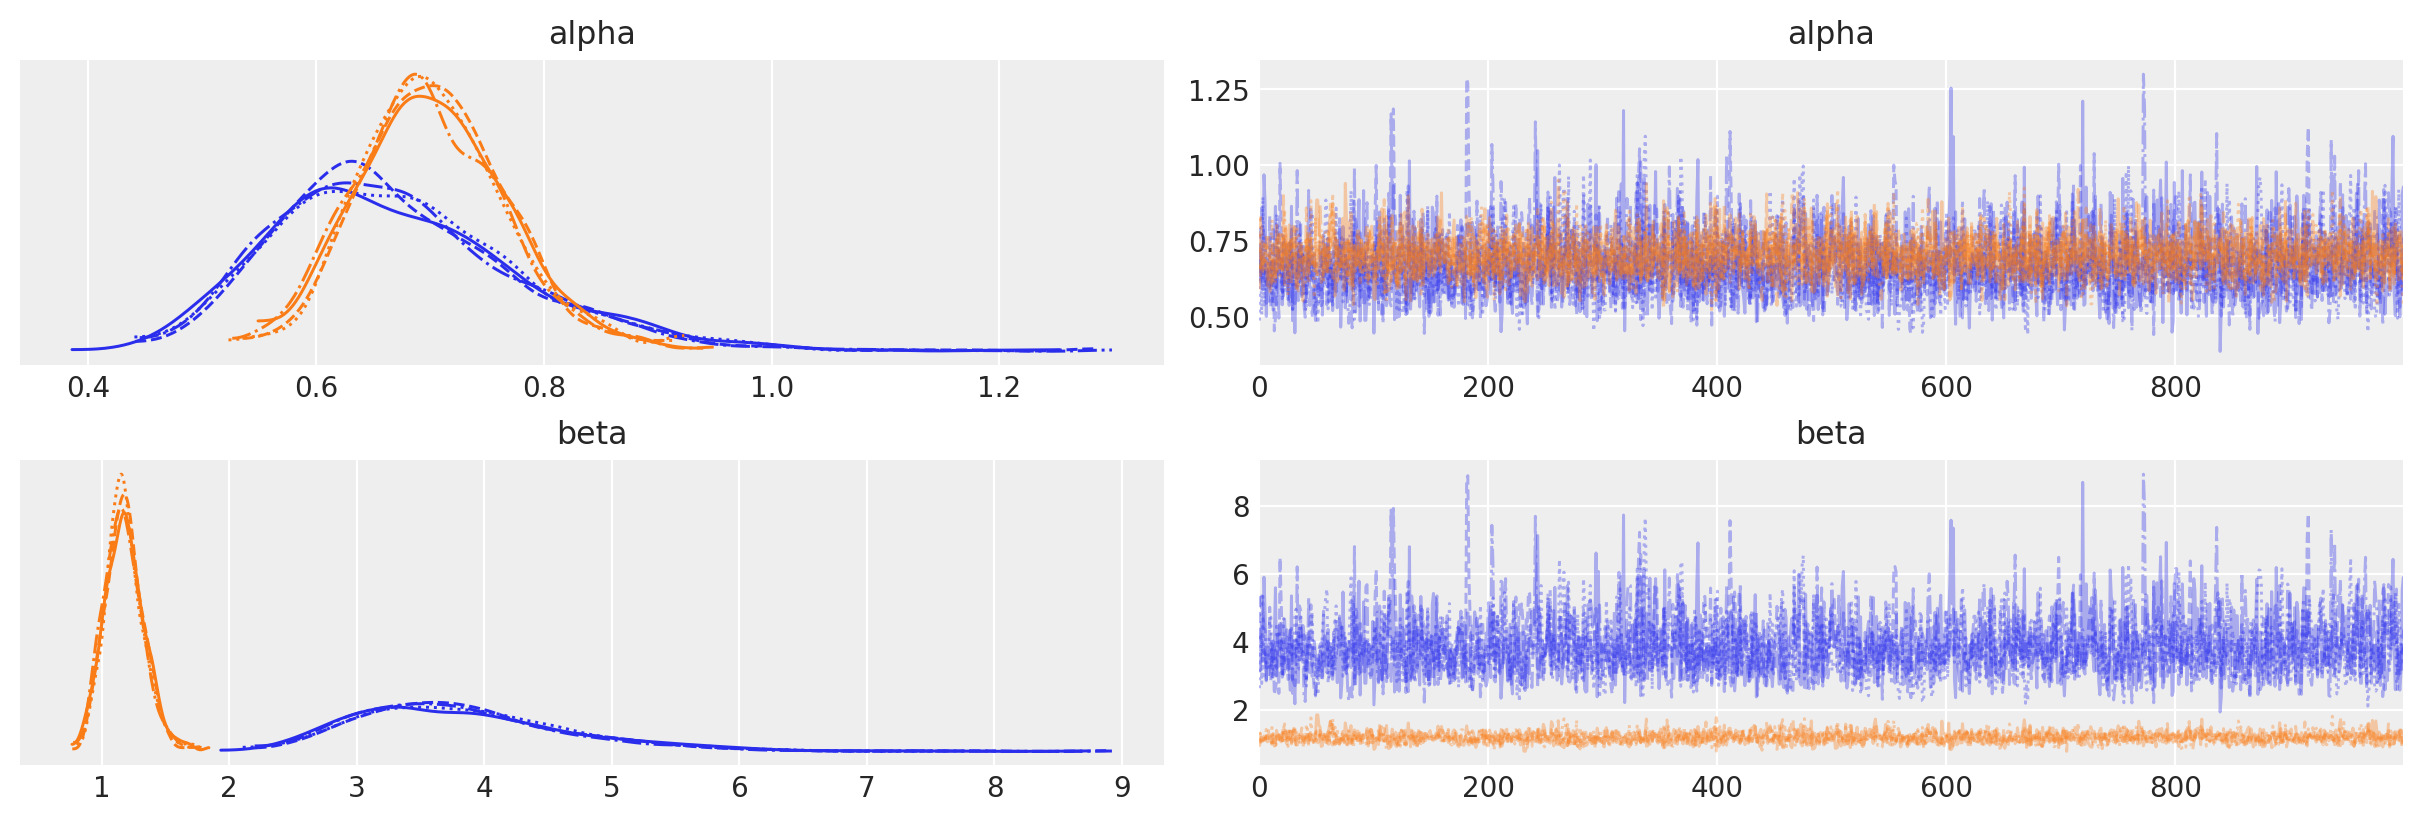

In [25]:
az.plot_trace(sbg.idata,var_names=["alpha","beta"])

## Quick Covariate Example

In this particular dataset, both cohorts start in the same time period and could also be indicated as a simple binary covariate:

In [12]:
dataset["highend_customer"] = np.where(dataset["cohort"] == "highend", 1, 0)
covariate_data = dataset.assign(cohort="population")

covariate_data

,customer_id,recency,T,cohort,highend_customer
0,1,1,8,population,1
1,2,1,8,population,1
2,3,1,8,population,1
3,4,1,8,population,1
4,5,1,8,population,1
...,...,...,...,...,...
1995,1996,8,8,population,0
1996,1997,8,8,population,0
1997,1998,8,8,population,0
1998,1999,8,8,population,0


Model fitting takes more time with covariates compared to cohorts. It still works great for a dataset of this size, but with larger datasets, a gradient-free sampler like [`DEMetropolisZ`](https://www.pymc.io/projects/docs/en/v5.6.1/api/generated/pymc.DEMetropolisZ.html) will converge in less time. If it gets stuck due to posterior geometry, use MAP fits instead.

In [27]:
sbg = clv.ShiftedBetaGeoModel(
    data=covariate_data,
        model_config = {
        "dropout_covariate_cols": ["highend_customer"],
    }
)
sbg.build_model()
sbg.fit(fit_method='demz',tune=3000, draws=3000) #'demz' needs a lot of tunes/draws
sbg.thin_fit_result(keep_every=2)
#sbg.fit_summary(var_names=["alpha","beta"])

Multiprocess sampling (4 chains in 4 jobs)
DEMetropolisZ: [phi, kappa, dropout_coefficient_alpha, dropout_coefficient_beta]


Output()

Sampling 4 chains for 3_000 tune and 3_000 draw iterations (12_000 + 12_000 draws total) took 4 seconds.


Shifted Beta-Geometric
                      phi ~ Uniform(0, 1)
                    kappa ~ Pareto(1, 1)
dropout_coefficient_alpha ~ Normal(0, 1)
 dropout_coefficient_beta ~ Normal(0, 1)
              alpha_scale ~ Deterministic(f(kappa, phi))
               beta_scale ~ Deterministic(f(kappa, phi))
                    alpha ~ Deterministic(f(dropout_coefficient_alpha, kappa, phi))
                     beta ~ Deterministic(f(dropout_coefficient_beta, kappa, phi))
                  dropout ~ Censored(ShiftedBetaGeometric(alpha, beta), -inf, <constant>)

## Contrasting posterior inferences with the repo MLE estimates

The sBG model has 2 population parameters of interest: `alpha` and `beta`. 
These parameters define the population distribution of the latent churn rate distribution `theta`. 
The larger the values of `alpha` and `beta`, the more homogenous the churn rates across different customers. 

The ratio of `alpha` to `beta` tells us the expected churn rates. If `alpha/beta == 0.1`, we expect the average customer to have a `0.1` probability of churning between each time period.

The model fitting agrees with the Maximum Likelihood estimates described in the original paper.
In addition, MCMC sampling, gives us useful information about the uncertainty of the fits.

array([[<Axes: title={'center': 'alpha_scale'}>,
        <Axes: title={'center': 'alpha_scale'}>],
       [<Axes: title={'center': 'beta_scale'}>,
        <Axes: title={'center': 'beta_scale'}>],
       [<Axes: title={'center': 'dropout_coefficient_alpha'}>,
        <Axes: title={'center': 'dropout_coefficient_alpha'}>],
       [<Axes: title={'center': 'dropout_coefficient_beta'}>,
        <Axes: title={'center': 'dropout_coefficient_beta'}>]],
      dtype=object)

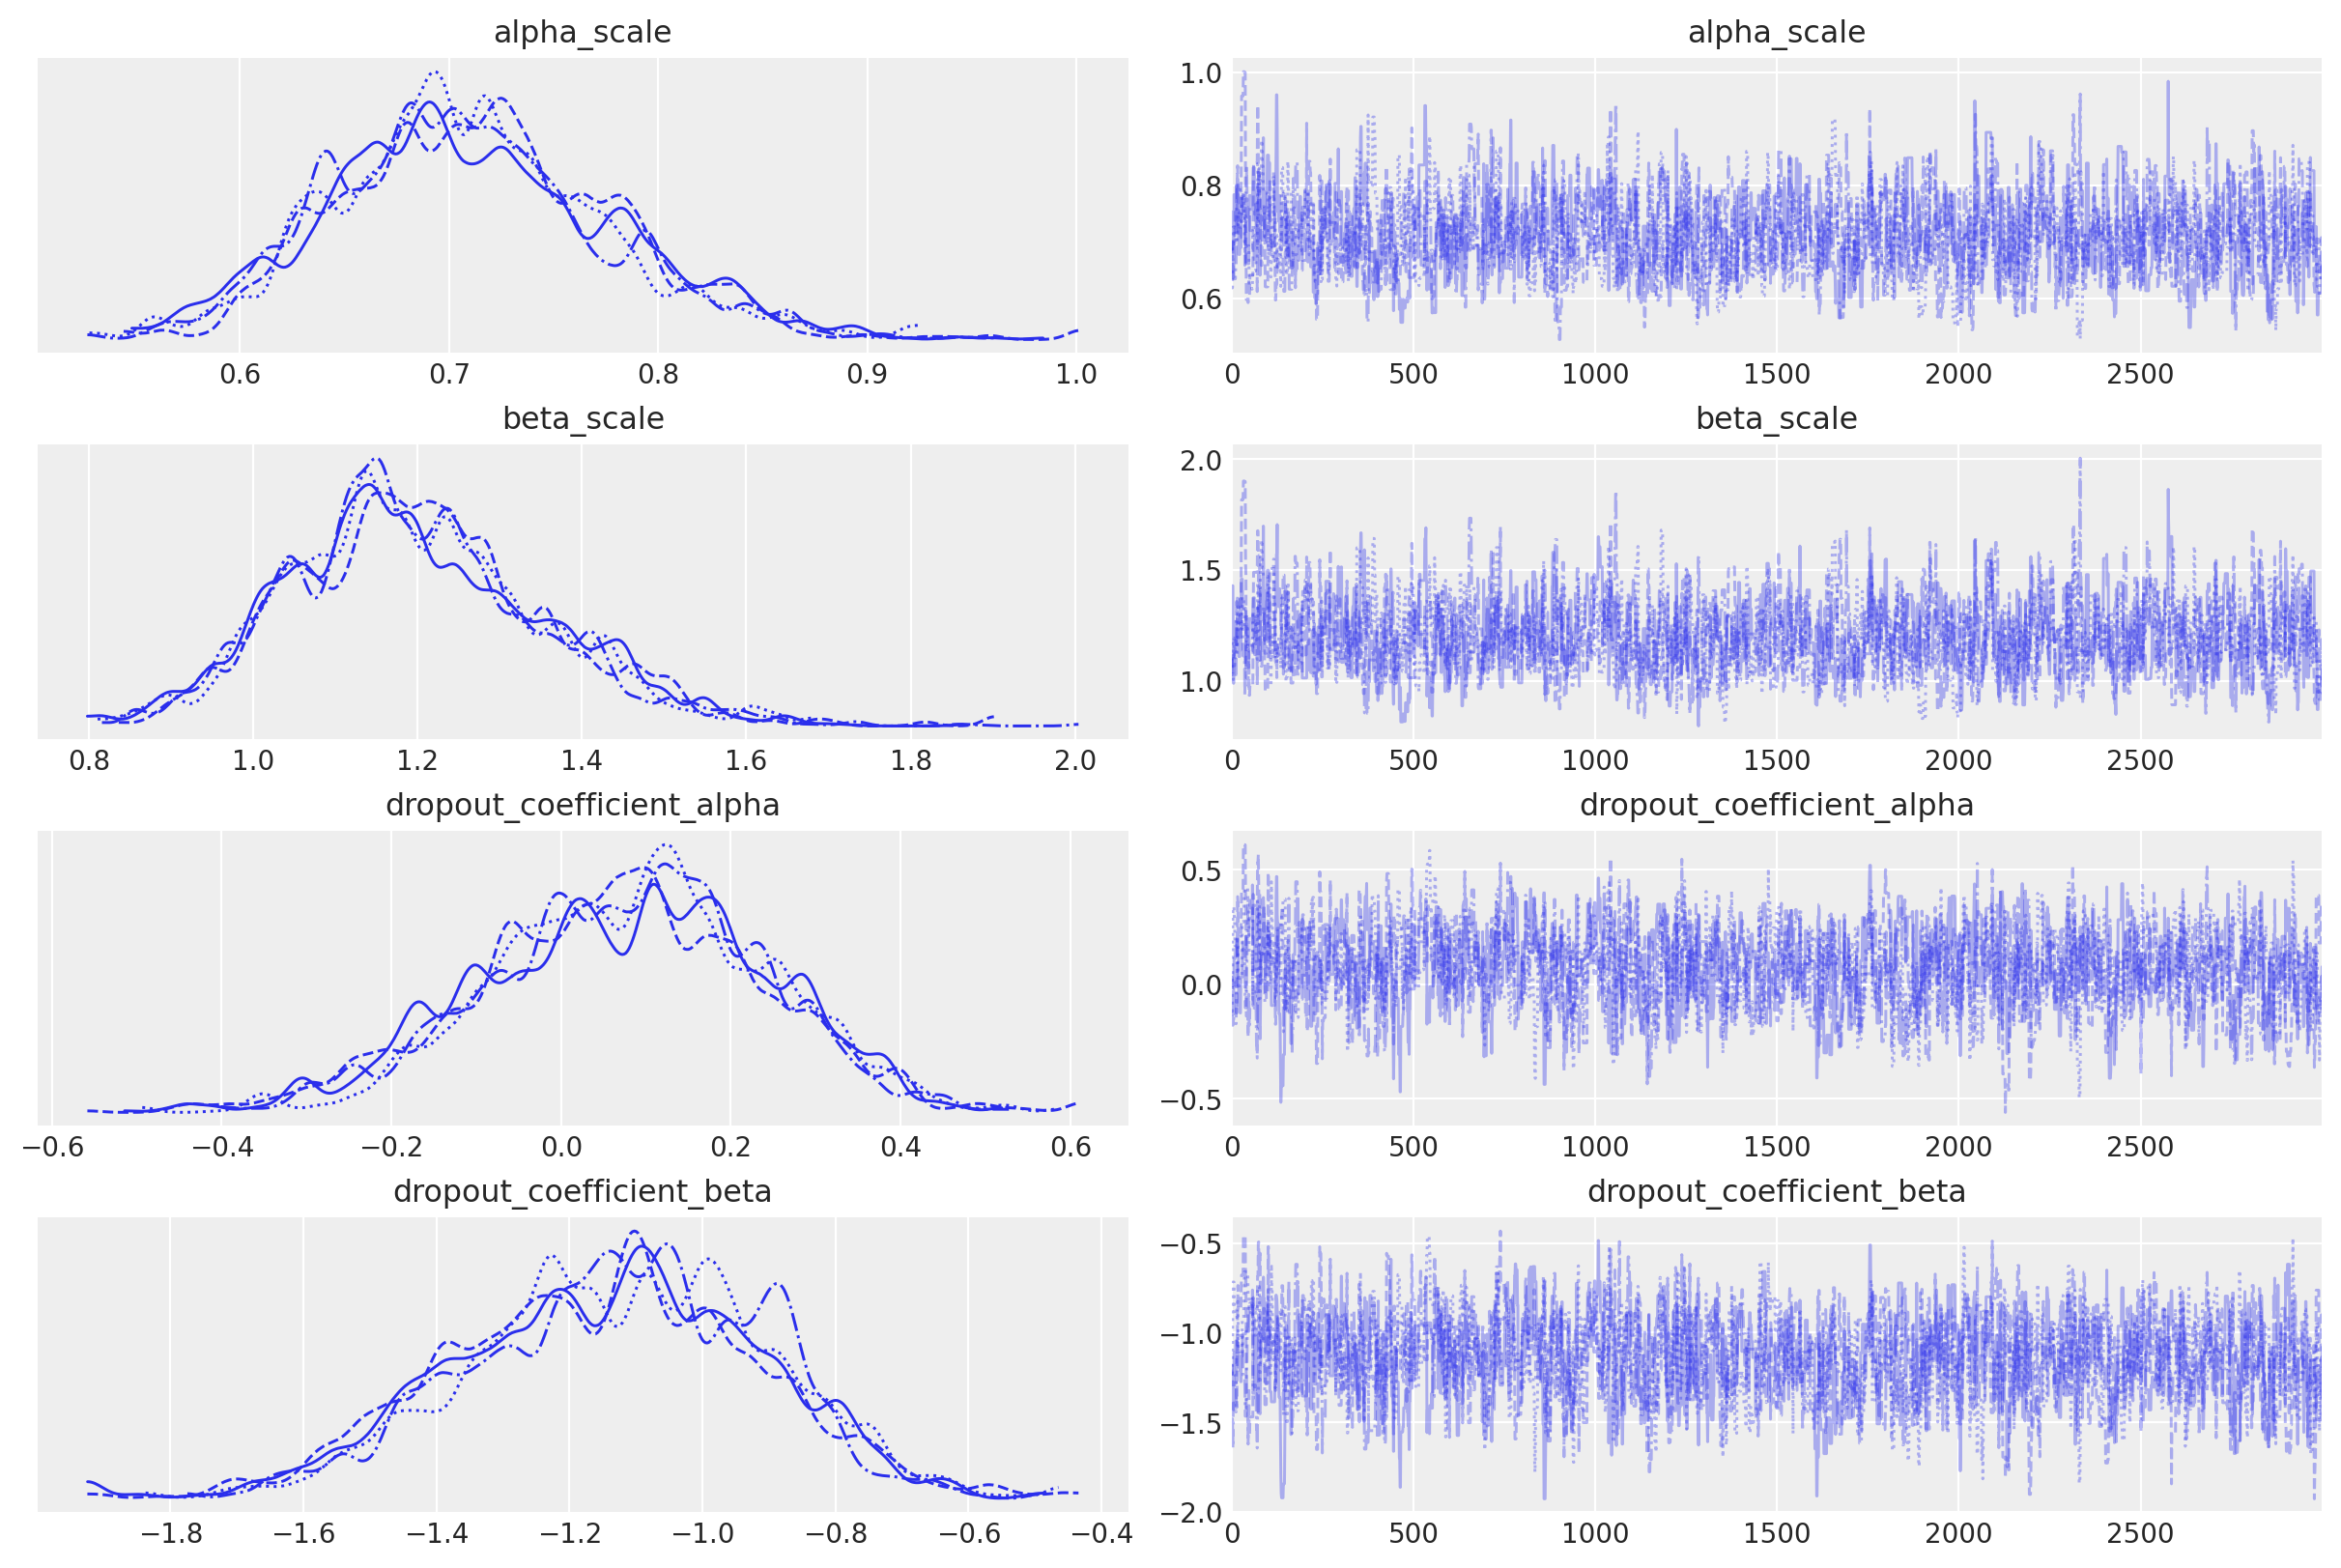

In [28]:

az.plot_trace(sbg.idata,var_names=["alpha_scale","beta_scale", "dropout_coefficient_alpha", "dropout_coefficient_beta"])

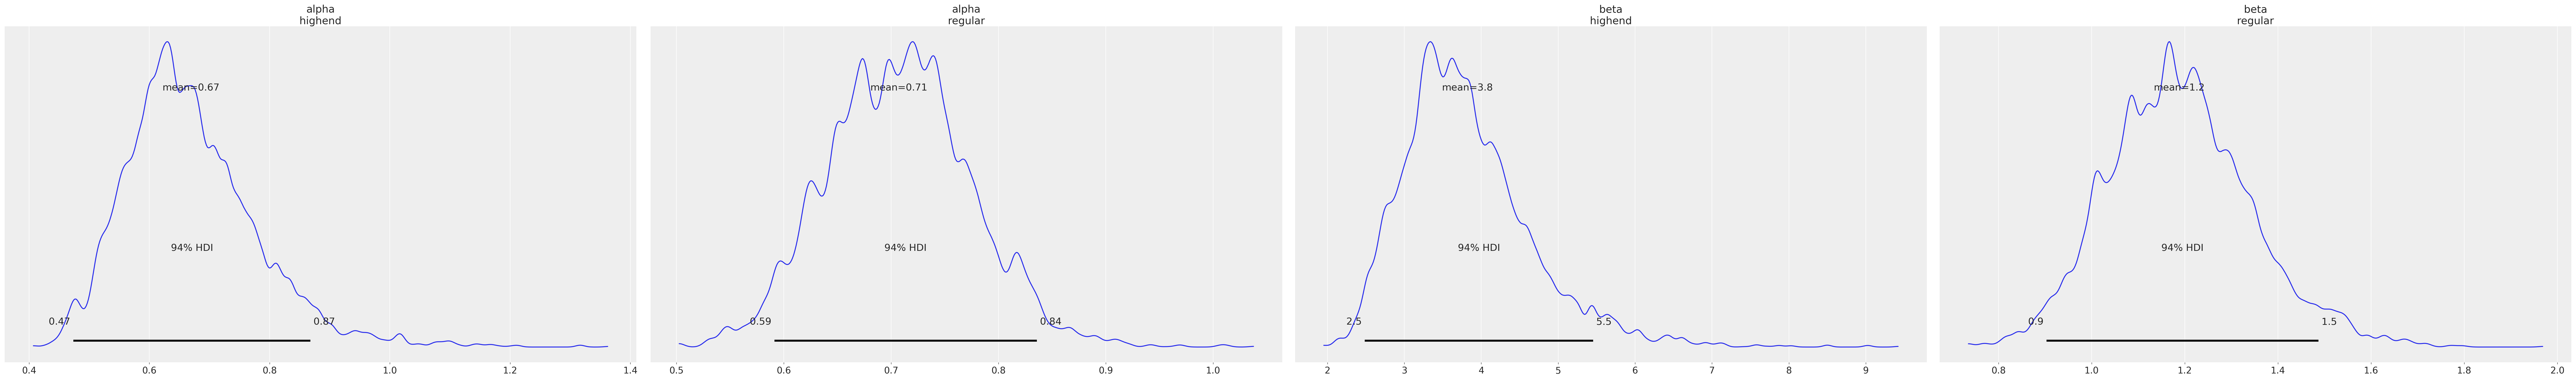

In [59]:
# ask AI to overlay MLE estimates here
# MLE estimates from the paper
ref_val = {
    "highend": [0.668, 3.806],
    "regular": [0.704, 1.182],
}
# Map cohort-wise [alpha, beta] refs to ArviZ variable labels
ref_val_map = {}
for cohort, (a_ref, b_ref) in ref_val.items():
    ref_val_map[f"alpha\n{cohort}"] = a_ref
    ref_val_map[f"beta\n{cohort}"]  = b_ref
   
az.plot_posterior(
    sbg.idata,
    var_names=["alpha", "beta"],
    ref_val=ref_val_map,
);

**Below plotting code cells were lifted directly from sBG-Individual notebook and require adaptation:**

In [29]:
# obs = df["highend"]/100

# plt.plot(survive_pred,color="b", label="predicted")
# plt.plot(obs,color="k", label="observed")
# plt.ylabel("Survival Rate")
# plt.legend()
# plt.title("High-End Customers MAP")

# plt.plot(reg_retention_cohort[:8],color="b", label="predicted")
# plt.plot(retention_rate_regular_obs[:8],color="k", label="observed")
# plt.ylabel("Retention Rate")
# plt.legend()
# plt.title("Regular Customers MCMC Estimated with Cohorts")

Figures 4 and 5 show the predicted average churn and retention trends for the two groups.
We can see that predictions nicely match the observed data (black line), even when extrapolating into the time periods that were held-out when fitting the model.

The plots also highlight an interesting implication from the model: 
the retention rates are expected to increase over time, as the more precarious customers gradually drop out. This is a direct consequence of modelling individual churn rates as being fixed over time.

In [30]:
# az.plot_hdi(
#     weeks_,
#     hi_retention.mean("customer_id"),
#     hdi_prob=0.95,
#     color="C0",
#     fill_kwargs={"label": "high end"},
# )
# az.plot_hdi(
#     weeks_,
#     lo_retention.mean("customer_id"),
#     hdi_prob=0.95,
#     color="C1",
#     fill_kwargs={"label": "regular"},
# )

# plt.plot(weeks_, retention_rate_highend_obs, color="k", label="observed")
# plt.plot(weeks_, retention_rate_regular_obs, color="k")

# plt.axvline(7, ls="--", color="k")
# plt.ylim([0.5, 1.05])
# plt.ylabel("Retention Rate")
# plt.legend()
# plt.title("Figure 5");

In [60]:
# filter dataset to only active customers
pred_data=dataset.query("recency==T")

# predict retention rate and convert to dataframe for downstream processing
pred_cohort_retention = sbg.expected_retention_rate(pred_data,future_t=0).mean(("chain","draw"))
pred_cohort_retention.to_dataframe(name="retention").reset_index()

,cohort,customer_id,retention
0,highend,510,0.942107
1,highend,511,0.942107
2,highend,512,0.942107
3,highend,513,0.942107
4,highend,514,0.942107
...,...,...,...
727,regular,1996,0.920621
728,regular,1997,0.920621
729,regular,1998,0.920621
730,regular,1999,0.920621


Below cell is a WIP for plotting a time period trend for model evaluation for Probability Alive.

In [61]:
max_T = 12
cohort_names = np.array(["regular","highend"])
cohorts_covar = np.array([0,1])
T_rng = np.arange(1,max_T+1,1)


pred_data = pd.DataFrame(
    {
        "customer_id": np.arange(1,1+max_T*2,1),
        "T": np.repeat(T_rng,len(cohort_names)),
        "cohort": np.tile(cohort_names,max_T),
        "covar_cohort": np.tile(cohorts_covar,max_T),
    }
)

# retention rate is estimated from T-1 time periods, reducing array length by 1
retention_array = pred_data.query("T <=12").copy()

sbg.expected_probability_alive(
            data=retention_array,
            future_t=0,
        )

# expected_purchases_over_time = xr.concat(
#     objs=[
#         sbg.expected_retention_rate(
#             data=time_data,
#             future_t=0,
#         )
#         for t in range(time_periods)
#     ],
#     dim="t",
# ).transpose(..., "t")

# unique_cohorts = np.unique(expected_purchases_over_time.coords["cohort"].values)

# for cohort in unique_cohorts:
#     print(expected_purchases_over_time.sel(cohort=cohort).mean("t"))

<xarray.DataArray (chain: 4, draw: 3000, cohort: 24)> Size: 2MB
array([[[0.63418741, 0.8381883 , 0.48044675, ..., 0.40320935,
         0.17093076, 0.38766708],
        [0.630891  , 0.84678361, 0.47767873, ..., 0.37836717,
         0.17099589, 0.36103545],
        [0.630891  , 0.84678361, 0.47767873, ..., 0.37836717,
         0.17099589, 0.36103545],
        ...,
        [0.62502837, 0.86766426, 0.47161546, ..., 0.39247136,
         0.16781574, 0.37326491],
        [0.62502837, 0.86766426, 0.47161546, ..., 0.39247136,
         0.16781574, 0.37326491],
        [0.62502837, 0.86766426, 0.47161546, ..., 0.39247136,
         0.16781574, 0.37326491]],

       [[0.61908111, 0.8696243 , 0.45715121, ..., 0.38412584,
         0.14222637, 0.36423503],
        [0.61908111, 0.8696243 , 0.45715121, ..., 0.38412584,
         0.14222637, 0.36423503],
        [0.61908111, 0.8696243 , 0.45715121, ..., 0.38412584,
         0.14222637, 0.36423503],
...
        [0.62800669, 0.85722171, 0.48236619, ..., 0.40776351,
         0.19107558, 0.39054565],
        [0.62800669, 0.85722171, 0.48236619, ..., 0.40776351,
         0.19107558, 0.39054565],
        [0.62800669, 0.85722171, 0.48236619, ..., 0.40776351,
         0.19107558, 0.39054565]],

       [[0.6317876 , 0.85167867, 0.47557498, ..., 0.41657765,
         0.16294505, 0.40031841],
        [0.6317876 , 0.85167867, 0.47557498, ..., 0.41657765,
         0.16294505, 0.40031841],
        [0.6317876 , 0.85167867, 0.47557498, ..., 0.41657765,
         0.16294505, 0.40031841],
        ...,
        [0.63678982, 0.85271458, 0.48155622, ..., 0.38561303,
         0.16776427, 0.36794173],
        [0.62940952, 0.84618764, 0.47386464, ..., 0.38143379,
         0.16381622, 0.36428676],
        [0.62940952, 0.84618764, 0.47386464, ..., 0.38143379,
         0.16381622, 0.36428676]]], shape=(4, 3000, 24))
Coordinates:
  * chain        (chain) int64 32B 0 1 2 3
  * draw         (draw) int64 24kB 0 1 2 3 4 5 ... 2994 2995 2996 2997 2998 2999
  * cohort       (cohort) object 192B 'regular' 'highend' ... 'highend'
    customer_id  (cohort) int64 192B 1 2 3 4 5 6 7 8 ... 17 18 19 20 21 22 23 24

## Full Example with Cohorts and Covariates

### Simulate Data from Follow-Up Paper
Adapt below code to create time-period cohorts with highend & regular covariate customers mixed into each.

In [33]:
import numpy as np
import pandas as pd

# Cohort table from the markdown (empty cells omitted)
# only need the params for unit testing
# alpha 3.80, beta = 15.20
cohort_counts = {
    2001: {2001: 10000, 2002: 8000, 2003: 6480, 2004: 5307, 2005: 4391},
    2002: {2002: 10000, 2003: 8000, 2004: 6480, 2005: 5307},
    2003: {2003: 10000, 2004: 8000, 2005: 6480},
    2004: {2004: 10000, 2005: 8000},
    2005: {2005: 10000},
}

# alpha=0.067, beta=0.267
case2 = {
    2003: {2003: 10000, 2004: 8000, 2005: 7600, 2006: 7383, 2007: 7235},
    2004: {2004: 10000, 2005: 8000, 2006: 7600, 2007: 7383},
    2005: {2005: 10000, 2006: 8000, 2007: 7600},
    2006: {2006: 10000, 2007: 8000},
    2007: {2007: 10000},
}
# (Bottom totals row is intentionally ignored)

rows = []
for cohort, year_counts in cohort_counts.items():
    years_sorted = sorted(year_counts)
    ages = [y - cohort for y in years_sorted]
    S = [year_counts[y] for y in years_sorted]  # survivors per age
    last_t = ages[-1]  # observation window for this cohort (right-censoring time T)

    # Churn in interval t -> t+1 (event observed at t)
    for t in range(len(S) - 1):
        count = S[t] - S[t + 1]
        if count > 0:
            rows.append({"cohort": cohort, "recency": t, "T": last_t, "count": count})

    # Right-censored at last observed age (still active)
    if S[-1] > 0:
        rows.append({"cohort": cohort, "recency": last_t, "T": last_t, "count": S[-1]})

counts_df = pd.DataFrame(rows)

# Expand to one row per customer
t_churn_array = np.repeat(counts_df["recency"].to_numpy(), counts_df["count"].to_numpy())
T_array = np.repeat(counts_df["T"].to_numpy(), counts_df["count"].to_numpy())
cohort_array = np.repeat(counts_df["cohort"].to_numpy(), counts_df["count"].to_numpy())
customer_id = np.arange(t_churn_array.size)

case_1_2_df = pd.DataFrame(
    {
        "customer_id": customer_id + 1,
        "recency": t_churn_array + 1,
        "T": T_array + 1,
        "cohort": cohort_array,
    }
).astype({"customer_id": int, "recency": int, "T": int, "cohort": str})

#df.to_csv("sbg_cohorts.csv",index=False)

These additional predictive methods are described in https://faculty.wharton.upenn.edu/wp-content/uploads/2012/04/Fader_hardie_contractual_mksc_10.pdf

In [34]:
fit_case_1_2_df = case_1_2_df.query("T>1")

sbg_case1_2 = clv.ShiftedBetaGeoModel(
    data = fit_case_1_2_df,
    model_config = {
        "alpha": Prior("HalfFlat", dims="cohort"),
        "beta": Prior("HalfFlat", dims="cohort"),
    }
)
sbg_case1_2.fit(method="map")

Output()

Inference data with groups:
	> posterior
	> observed_data
	> fit_data

### Latent Dropout Distribution for Customer Population
Plotting dropout distributions by cohort is more intuitive than the alpha and beta parameters for each, but the below code will require modification if model has not been fit with MAP:

Text(0.5, 1.0, 'Dropout Distributions by Cohort')

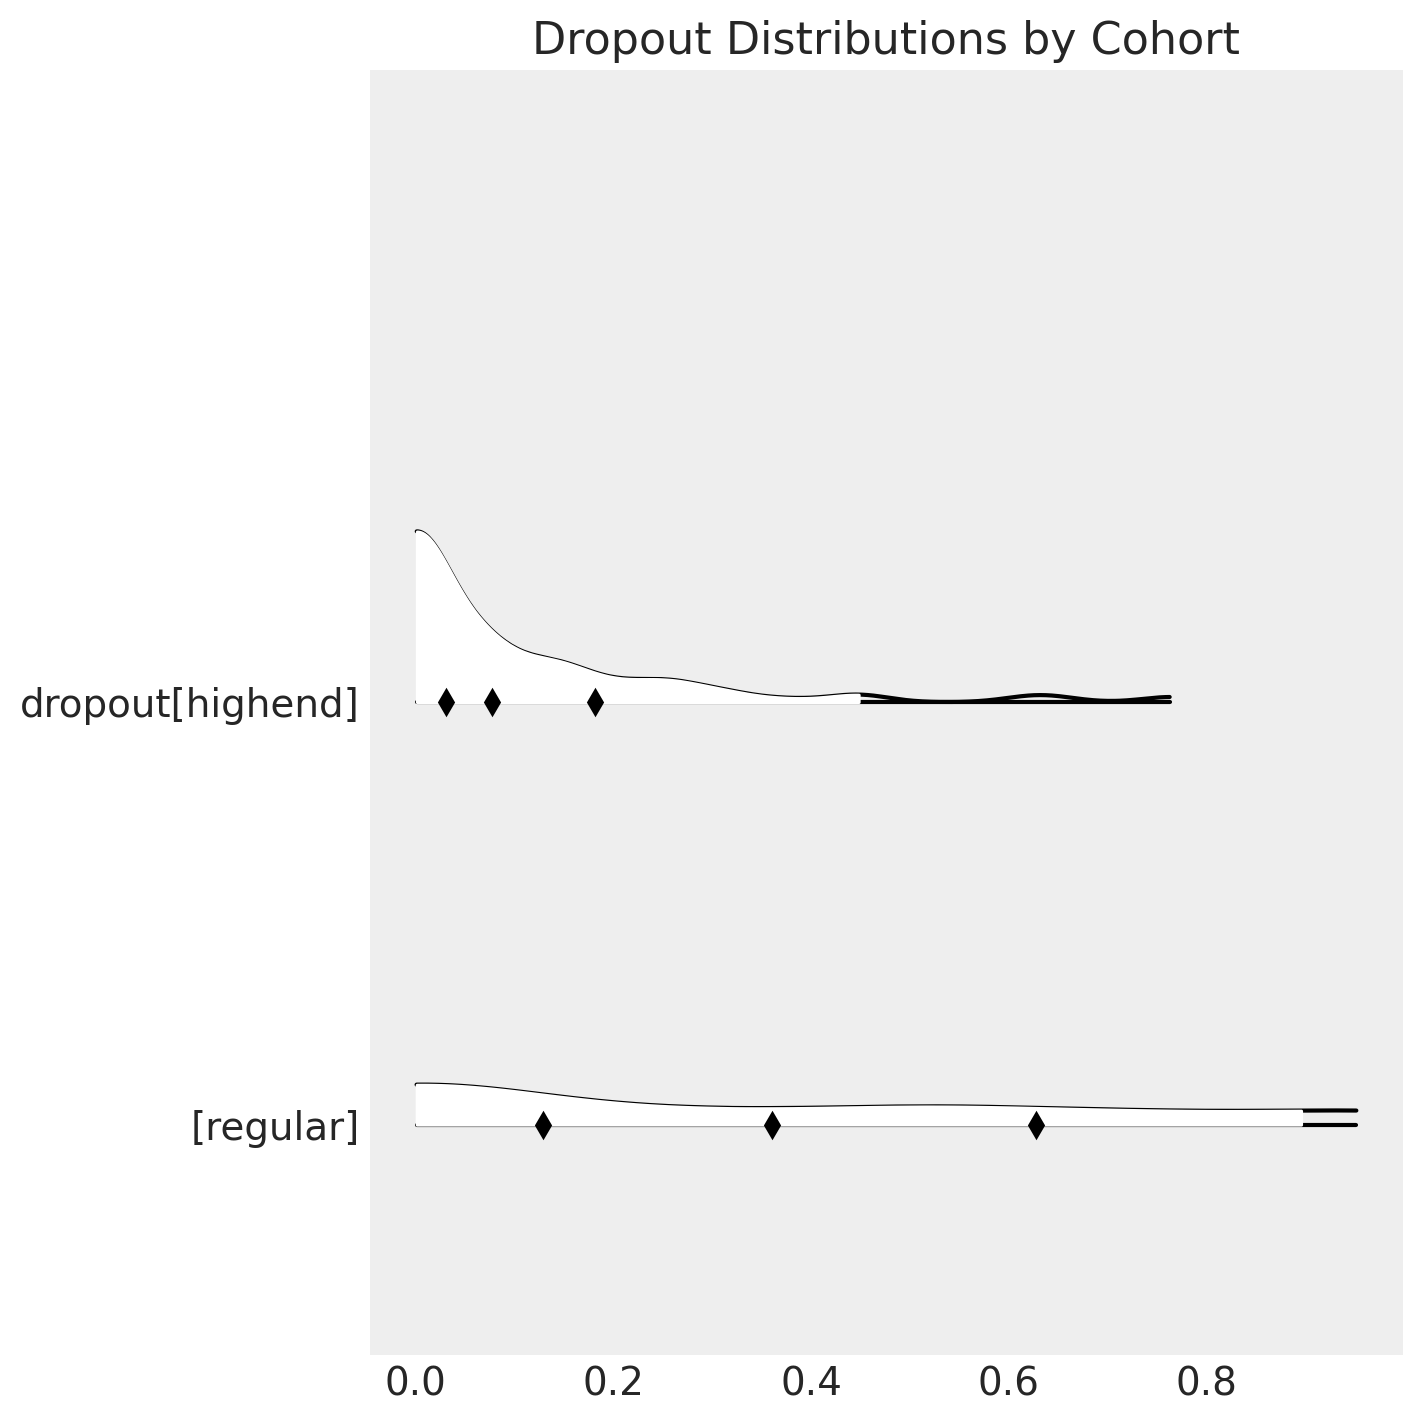

In [67]:
# Extract alpha and beta from fit results
alpha = sbg.fit_result["alpha"]
beta = sbg.fit_result["beta"]

# Generate 100 random samples from Beta distribution for each cohort
rng = np.random.default_rng(42)
n_samples = 100

cohorts = alpha.coords['cohort'].values
dropout_samples = np.array([
    rng.beta(
        alpha.sel(cohort=c).values.item(),  # Use .item() to get scalar
        beta.sel(cohort=c).values.item(),   # Use .item() to get scalar
        size=n_samples
    )
    for c in cohorts
]).T  # Transpose to get (samples, cohorts) shape

# Create xarray DataArray with chain, draw, and cohort dimensions
# Reshape to add chain dimension (1 chain, n_samples draws)
dropout = xr.DataArray(
    dropout_samples[np.newaxis, :, :],  # Add chain dimension
    dims=("chain", "draw", "cohort"),
    coords={
        "chain": [0],
        "draw": np.arange(n_samples),
        "cohort": cohorts,
    },
    name="dropout",
)

# Convert to InferenceData
dropout_idata = az.convert_to_inference_data(dropout)

# Plot with arviz
axes = az.plot_forest(
    dropout_idata,
    kind='ridgeplot',
    combined=True,
    colors='white',
    ridgeplot_overlap=1,
    ridgeplot_truncate=False,
    ridgeplot_quantiles=[.25,.5,.75],
    figsize=(7,7),
)
axes[0].set_title("Dropout Distributions by Cohort")

array([<Axes: title={'center': '94.0% HDI'}>], dtype=object)

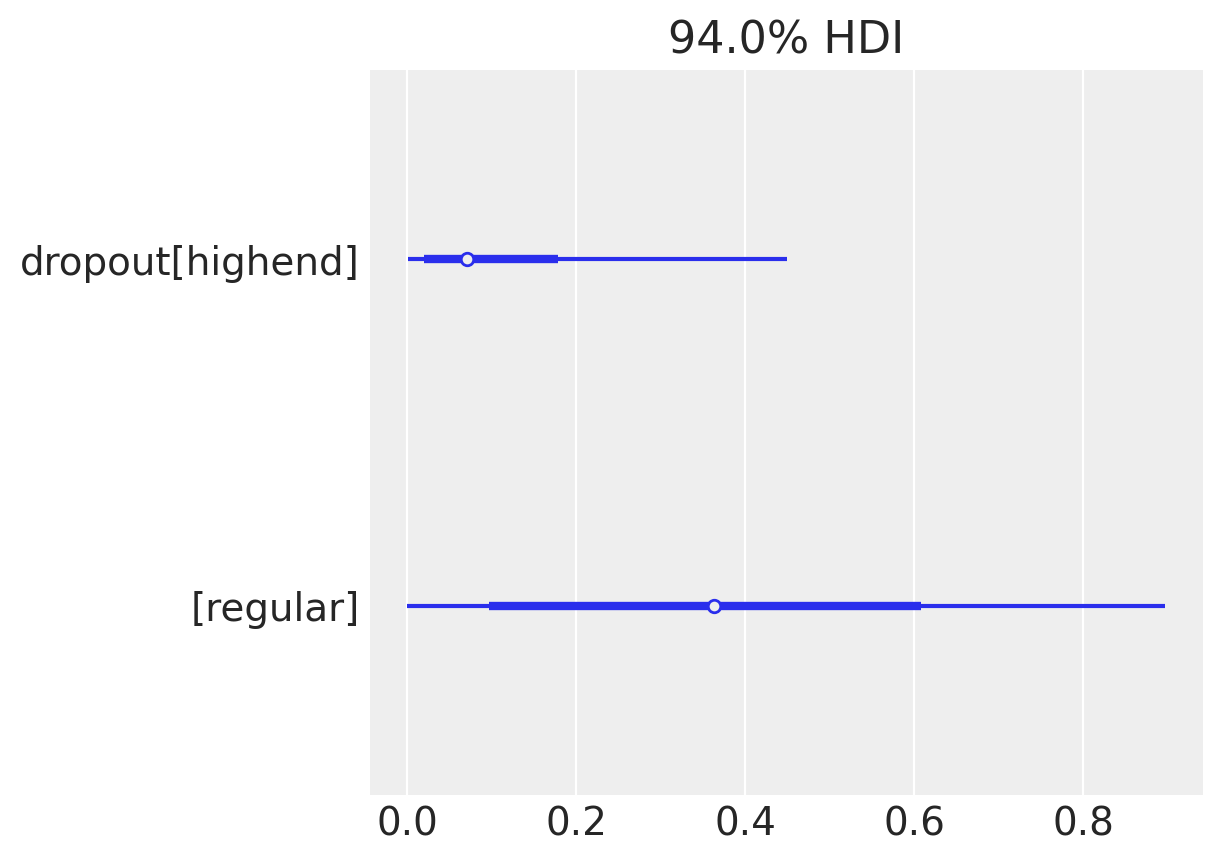

In [66]:
az.plot_forest(dropout_idata)

In [40]:
%load_ext watermark
%watermark -n -u -v -iv -w -p pymc,pytensor

Last updated: Wed Nov 05 2025

Python implementation: CPython
Python version       : 3.12.11
IPython version      : 9.4.0

pymc    : 5.25.1
pytensor: 2.31.7

pymc_extras   : 0.4.0
pytensor      : 2.31.7
pandas        : 2.3.1
pymc          : 5.25.1
arviz         : 0.22.0
matplotlib    : 3.10.3
numpy         : 2.2.6
pymc_marketing: 0.17.0
xarray        : 2025.7.1

Watermark: 2.5.0

